### Define Parameters

Definition of parameters for importing the dataset and for training.

In [1]:
seq_len = 100
pred_len = 200

batch_size = 256
max_epochs = 50

### Import libraries and dataset

Import all the needed libraries and the dataset with the class defined inside of weather/dataset.py

In [2]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

from model import MICN

from weather.dataset import weather_dataset

dataset = weather_dataset(seq_len=seq_len, pred_len=pred_len)

train_set, test_set, valid_set = dataset.split()

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

Found files: ['mpi_roof_2023a.csv', 'mpi_roof_2021b.csv', 'mpi_roof_2021a.csv', 'mpi_roof_2020b.csv', 'mpi_roof_2023b.csv', 'mpi_roof_2022a.csv', 'mpi_roof_2020a.csv', 'mpi_roof_2022b.csv']


/home/filippo/Desktop/nn_project/weather/dataset.py:60: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['month'] = dates_df["Date Time"].apply(lambda row:row.month,1)
/home/filippo/Desktop/nn_project/weather/dataset.py:61: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['day'] = dates_df["Date Time"].apply(lambda row:row.day,1)
/home/filippo/Desktop/nn_project/weather/dataset.py:62: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['weekday'] = dates_df["Date Time"].apply(lambda row:row.weekday(),1)
/home/filippo/Desktop/nn_project/weather/dataset.py:63: FutureWarning: the

Found a total of 210441 samples.


/home/filippo/Desktop/nn_project/weather/dataset.py:64: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['minute'] = dates_df["Date Time"].apply(lambda row:row.minute,1)


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

model = MICN(seq_len, pred_len, device=device)

Using device cuda:0


In [6]:
for seq_times, sequence, true_times, true in tqdm(test_loader):
    seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
    out = model(sequence, seq_times, true_times)
    break

  0%|          | 0/81 [00:00<?, ?it/s]


## Train the model

This block includes a loop over each epochs where each of them is made by  
    - Train loop: this part is responsible of iterating over the shuffled train set and for each train sample an optimization step is performed with the selected optimizer (Adam). Furthermore, to help convergence, I've used an exponentially decreasing learning rate; this mechanism scales down the learning rate once each 5 epochs by a rate gamma (0.9 in this case).  
    - Validation loop: the difference here is that gradients are not calculated on the model's output, the role of this part is to do early stopping when the model stops getting better on data which has not been seen during training, more precisely, when the validation performance does not get better after some epochs (patience) then the training is stopped because the model starts to overfit training data. Additionally, when the validation loss is better then the previously obtained a checkpoint of the model is saved.

In [4]:
criterion = nn.MSELoss(reduction='mean')
criterion = criterion.to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

train_losses = []
val_losses = []

patience = 3
epochs_without_improving = 0

best_epoch = -1
best_val_loss = 0

for epoch in range(max_epochs):
    print("Starting epoch", epoch+1)
    model.train()
    losses = []
    for seq_times, sequence, true_times, true in tqdm(train_loader):
        seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
        out = model(sequence, seq_times, true_times)
        
        loss = criterion(out, true)
        losses.append(loss.detach().item())

        loss.backward()
        optim.step()
    if epoch % 5 == 0:
        scheduler.step()
    avg_train_loss = np.mean(losses)
    print("Average train loss:", avg_train_loss)
    train_losses.append(avg_train_loss)
    
    model.eval()
    losses = []
    with torch.no_grad():
        for seq_times, sequence, true_times, true in tqdm(valid_loader):
            seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
            out = model(sequence, seq_times, true_times)
            
            loss = criterion(out, true)
            losses.append(loss.detach().item())
    avg_val_loss = np.mean(losses)
    print("Average validation loss:", avg_val_loss)
    val_losses.append(avg_val_loss)

    if best_epoch == -1 or avg_val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = avg_val_loss
        epochs_without_improving = 0

        save_name = "MICN_" + str(seq_len) + "_" + str(pred_len) + "_" + str(epoch+1) + ".pt"
        torch.save(model.state_dict(), save_name)
    else:
        epochs_without_improving += 1
    
    if epochs_without_improving > patience:
        print("Stopping at epoch", epoch+1)
        print("Best validation loss reached at epoch", best_epoch)
        model.load_state_dict(torch.load(save_name))
        epoch = best_epoch
        break

Starting epoch 1


  0%|          | 0/657 [00:00<?, ?it/s]/home/filippo/anaconda3/envs/nn_project/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/filippo/anaconda3/envs/nn_project/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 657/657 [00:36<00:00, 18.21it/s]


Average train loss: 217311.5861396499


100%|██████████| 82/82 [00:01<00:00, 44.20it/s]


Average validation loss: 171125.19073932926
Starting epoch 2


100%|██████████| 657/657 [00:35<00:00, 18.73it/s]


Average train loss: 190956.35590277778


100%|██████████| 82/82 [00:01<00:00, 42.80it/s]


Average validation loss: 149546.58041158537
Starting epoch 3


100%|██████████| 657/657 [00:38<00:00, 17.12it/s]


Average train loss: 170106.63586853122


100%|██████████| 82/82 [00:02<00:00, 40.72it/s]


Average validation loss: 131288.82888719512
Starting epoch 4


100%|██████████| 657/657 [00:35<00:00, 18.65it/s]


Average train loss: 152431.45220937976


100%|██████████| 82/82 [00:01<00:00, 44.24it/s]


Average validation loss: 115671.14510289633
Starting epoch 5


100%|██████████| 657/657 [00:34<00:00, 18.98it/s]


Average train loss: 137289.73108114535


100%|██████████| 82/82 [00:01<00:00, 43.69it/s]


Average validation loss: 102173.62099847561
Starting epoch 6


100%|██████████| 657/657 [00:35<00:00, 18.67it/s]


Average train loss: 124253.670769121


100%|██████████| 82/82 [00:01<00:00, 43.66it/s]


Average validation loss: 90484.37223704268
Starting epoch 7


100%|██████████| 657/657 [00:35<00:00, 18.74it/s]


Average train loss: 113527.84416619102


100%|██████████| 82/82 [00:01<00:00, 42.97it/s]


Average validation loss: 81261.57536204268
Starting epoch 8


100%|██████████| 657/657 [00:36<00:00, 18.13it/s]


Average train loss: 104668.14739107687


100%|██████████| 82/82 [00:02<00:00, 40.04it/s]


Average validation loss: 73130.29897103658
Starting epoch 9


100%|██████████| 657/657 [00:36<00:00, 18.01it/s]


Average train loss: 96878.1506849315


100%|██████████| 82/82 [00:01<00:00, 44.16it/s]


Average validation loss: 65950.22318025914
Starting epoch 10


100%|██████████| 657/657 [00:34<00:00, 18.85it/s]


Average train loss: 90068.31116818874


100%|██████████| 82/82 [00:01<00:00, 44.16it/s]


Average validation loss: 59627.91377667683
Starting epoch 11


100%|██████████| 657/657 [00:34<00:00, 18.90it/s]


Average train loss: 84125.19761344178


100%|██████████| 82/82 [00:01<00:00, 43.98it/s]


Average validation loss: 54071.13152629573
Starting epoch 12


100%|██████████| 657/657 [00:35<00:00, 18.41it/s]


Average train loss: 79147.65772450533


100%|██████████| 82/82 [00:01<00:00, 43.66it/s]


Average validation loss: 49667.18378429878
Starting epoch 13


100%|██████████| 657/657 [00:34<00:00, 18.77it/s]


Average train loss: 75057.85424395929


100%|██████████| 82/82 [00:01<00:00, 44.11it/s]


Average validation loss: 45768.54015815549
Starting epoch 14


100%|██████████| 657/657 [00:34<00:00, 19.02it/s]


Average train loss: 71509.4916821252


100%|██████████| 82/82 [00:01<00:00, 44.17it/s]


Average validation loss: 42355.26848323171
Starting epoch 15


100%|██████████| 657/657 [00:34<00:00, 19.01it/s]


Average train loss: 68471.45673991629


100%|██████████| 82/82 [00:01<00:00, 44.22it/s]


Average validation loss: 39419.44912347561
Starting epoch 16


100%|██████████| 657/657 [00:34<00:00, 19.01it/s]


Average train loss: 65928.20996242389


100%|██████████| 82/82 [00:01<00:00, 44.00it/s]


Average validation loss: 36938.06864519817
Starting epoch 17


100%|██████████| 657/657 [00:35<00:00, 18.71it/s]


Average train loss: 63816.90758775685


100%|██████████| 82/82 [00:01<00:00, 42.94it/s]


Average validation loss: 34990.96055640244
Starting epoch 18


100%|██████████| 657/657 [00:34<00:00, 18.93it/s]


Average train loss: 62172.16940758181


100%|██████████| 82/82 [00:01<00:00, 44.47it/s]


Average validation loss: 33333.875738376526
Starting epoch 19


100%|██████████| 657/657 [00:35<00:00, 18.63it/s]


Average train loss: 60787.77608923135


100%|██████████| 82/82 [00:01<00:00, 43.07it/s]


Average validation loss: 31940.374595083842
Starting epoch 20


100%|██████████| 657/657 [00:37<00:00, 17.70it/s]


Average train loss: 59677.010553415144


100%|██████████| 82/82 [00:01<00:00, 44.25it/s]


Average validation loss: 30771.824433117377
Starting epoch 21


100%|██████████| 657/657 [00:34<00:00, 19.07it/s]


Average train loss: 58768.45169211378


100%|██████████| 82/82 [00:01<00:00, 44.31it/s]


Average validation loss: 29826.794493140245
Starting epoch 22


100%|██████████| 657/657 [00:34<00:00, 19.08it/s]


Average train loss: 58126.17337923326


100%|██████████| 82/82 [00:01<00:00, 44.25it/s]


Average validation loss: 29132.788633765245
Starting epoch 23


100%|██████████| 657/657 [00:34<00:00, 19.07it/s]


Average train loss: 57638.54302226027


100%|██████████| 82/82 [00:01<00:00, 44.22it/s]


Average validation loss: 28555.642697217987
Starting epoch 24


100%|██████████| 657/657 [00:34<00:00, 19.06it/s]


Average train loss: 57222.20893978311


100%|██████████| 82/82 [00:01<00:00, 44.32it/s]


Average validation loss: 28119.901795922255
Starting epoch 25


100%|██████████| 657/657 [00:34<00:00, 19.07it/s]


Average train loss: 56995.41639316971


100%|██████████| 82/82 [00:01<00:00, 43.30it/s]


Average validation loss: 27824.364710365855
Starting epoch 26


100%|██████████| 657/657 [00:34<00:00, 18.94it/s]


Average train loss: 56941.348601598176


100%|██████████| 82/82 [00:01<00:00, 43.26it/s]


Average validation loss: 27650.004239710364
Starting epoch 27


100%|██████████| 657/657 [00:35<00:00, 18.68it/s]


Average train loss: 56886.59813784246


100%|██████████| 82/82 [00:01<00:00, 43.10it/s]


Average validation loss: 27583.56874047256
Starting epoch 28


100%|██████████| 657/657 [00:36<00:00, 18.16it/s]


Average train loss: 56993.573859042044


100%|██████████| 82/82 [00:01<00:00, 42.07it/s]


Average validation loss: 27583.41954077744
Starting epoch 29


100%|██████████| 657/657 [00:35<00:00, 18.55it/s]


Average train loss: 57108.927463850836


100%|██████████| 82/82 [00:01<00:00, 42.42it/s]


Average validation loss: 27626.40565453506
Starting epoch 30


100%|██████████| 657/657 [00:35<00:00, 18.75it/s]


Average train loss: 57253.2545840468


100%|██████████| 82/82 [00:01<00:00, 44.23it/s]


Average validation loss: 27696.03184546494
Starting epoch 31


100%|██████████| 657/657 [00:35<00:00, 18.73it/s]


Average train loss: 57433.96896998668


100%|██████████| 82/82 [00:01<00:00, 44.25it/s]


Average validation loss: 27806.247689596035
Starting epoch 32


100%|██████████| 657/657 [00:35<00:00, 18.53it/s]


Average train loss: 57637.57316043569


100%|██████████| 82/82 [00:02<00:00, 40.15it/s]

Average validation loss: 27905.243044969513
Stopping at epoch 32
Best validation loss reached at epoch 27


### Plot losses

From the plot below we can see how, after some epochs of training, the model stops to improve on unseen data while keeping getting better on the train set. For this reason, there is no benefit in continuing the training as it would only lead to worse generalization and thus worse performance. This behavior is what we call overfitting.

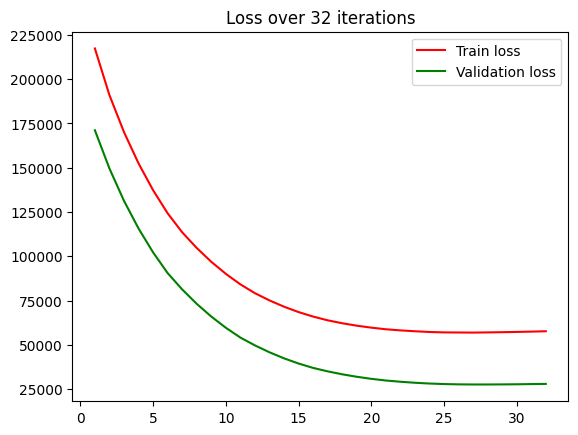

In [5]:
assert len(train_losses) == len(val_losses)
x = [i+1 for i in range(len(train_losses))]
plt.title("Loss over " + str(len(train_losses)) + " iterations")
plt.plot(x, train_losses, color="red", label="Train loss")
plt.plot(x, val_losses, color="green", label="Validation loss")
plt.legend()

plt.show()

## Evaluate on the test set

To test the model from a checkpoint you can execute this cell but make sure to also execute the first two since it requires the test set and some parameters.

In [3]:
if 'model' not in locals():
    save_name = "MICN_100_200_28.pt" # if model isn't defined change this line with the model you want to evaluate
    assert int(save_name[5:8]) == seq_len and int(save_name[9:12]) == pred_len
    model = MICN(seq_len, pred_len)
    model.load_state_dict(torch.load(save_name))
if 'device' not in locals():
    device = torch.device("cpu")
    
criterion = nn.MSELoss()
test_losses = []
model.eval()
with torch.no_grad():
    for seq_times, sequence, true_times, true in tqdm(test_loader):
        seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
        out = model(sequence, seq_times, true_times)
            
        loss = criterion(out, true)
        test_losses.append(loss.detach().item())
print("Average test loss:", np.mean(test_losses))
print("Average test loss per time step:", np.mean(test_losses)/pred_len)

100%|██████████| 81/81 [00:25<00:00,  3.20it/s]

Average test loss: 70416.55261381173
Average test loss per time step: 352.0827630690586


### Example of comparison between true and predicted values

In [26]:
for seq_times, sequence, true_times, true in test_loader:
    seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
    out = model(sequence, seq_times, true_times).detach()[0]
    print("avg loss per single time step", criterion(out, true[0]).item()/pred_len)
    print("Predicted True")
    for i in range(pred_len):
        print(out[i][1].cpu().numpy(), true[0][i][1].cpu().numpy())
    break

avg loss per single time step 173.866796875
Predicted True
17.2389 10.07
22.609104 10.32
17.958998 10.23
22.74022 10.22
21.782307 10.28
11.646132 10.72
20.578651 10.99
9.782032 11.36
19.43762 11.88
14.287766 12.3
21.841356 12.69
19.597767 13.27
15.2204685 13.76
28.00536 14.51
24.703417 15.24
21.699364 15.33
19.378704 15.68
26.747719 15.99
19.63111 16.53
3.0085135 16.85
15.946166 17.3
18.180391 17.58
27.020609 17.7
17.235775 17.98
23.673567 18.43
28.13021 18.44
18.295845 18.44
18.431252 19.0
19.556358 19.79
18.372204 20.6
18.55842 21.06
18.750736 20.89
18.934889 21.19
21.37128 21.64
20.4164 22.06
13.7168255 22.44
25.103046 22.15
20.999163 22.34
25.794891 22.39
20.635092 22.37
21.085987 22.37
19.219254 22.43
18.689238 22.25
25.766294 22.0
17.725327 21.95
21.18807 22.32
19.877151 22.36
20.854832 21.94
18.679502 22.05
21.646397 22.33
24.134468 22.33
19.455555 22.71
25.282114 22.4
27.237198 22.32
19.319849 21.04
18.172646 18.7
26.68005 18.42
26.611097 18.7
19.989902 18.5
24.932688 17.19
27.